# Bayesian NN

TODOs
- bayesian uncertainty: need to implement a BNN 
    


In [1]:
from epitome.constants import *
from epitome.models import *
from epitome.generators import *
from epitome.functions import *
from epitome.viz import *
from sklearn.metrics import roc_curve, auc
assert(tf.executing_eagerly())
import tensorflow_probability as tfp
import yaml

W0717 14:16:03.221287 140223369754368 __init__.py:308] Limited tf.compat.v2.summary API due to missing TensorBoard installation.
W0717 14:16:03.279280 140223369754368 __init__.py:335] Limited tf.summary API due to missing TensorBoard installation.
/data/miniconda3/envs/EpitomeEnv_c76/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
W0717 14:16:07.854274 140223369754368 __init__.py:308] Limited tf.compat.v2.summary API due to missing TensorBoard installation.


In [2]:
# load in user paths
# TODO: make a config file with data_path (downloaded from bin/download_deepsea_data.py) 
# and feature_name_file (at data/feature_name)
# My config.yml looks like:
# data_path: /data/akmorrow/epitome_data/numpy_data/
# feature_name_file: /home/eecs/akmorrow/epitome/data/feature_name

with open('/home/eecs/akmorrow/epitome/config.yml') as f:
    config = yaml.safe_load(f)
    
train_data, valid_data, test_data = load_deepsea_label_data(config["data_path"])
data = {Dataset.TRAIN: train_data, Dataset.VALID: valid_data, Dataset.TEST: test_data}
print(data[Dataset.TRAIN].shape, data[Dataset.VALID].shape, data[Dataset.TEST].shape)

(919, 2200000) (919, 4000) (919, 227512)


In [3]:
eligible_assays = ['DNase',
 'p300',
 'c-Myc',
 'ZNF274',
 'USF2',
 'TR4',
 'TBP',
 'TAF1',
 'SMC3',
 'Rad21',
 'RFX5',
 'Pol2(phosphoS2)',
 'Pol2',
 'Nrf1',
 'NRSF',
 'Mxi1',
 'Max',
 'MAZ',
 'JunD',
 'GABP',
 'EZH2',
 'CTCF',
 'COREST',
 'CHD2',
 'CEBPB']

matrix, cellmap, assaymap = get_assays_from_feature_file(eligible_assays = eligible_assays,
                                  eligible_cells = None, min_cells_per_assay =5, 
                                                         min_assays_per_cell=4)




## Plot Data Matrix

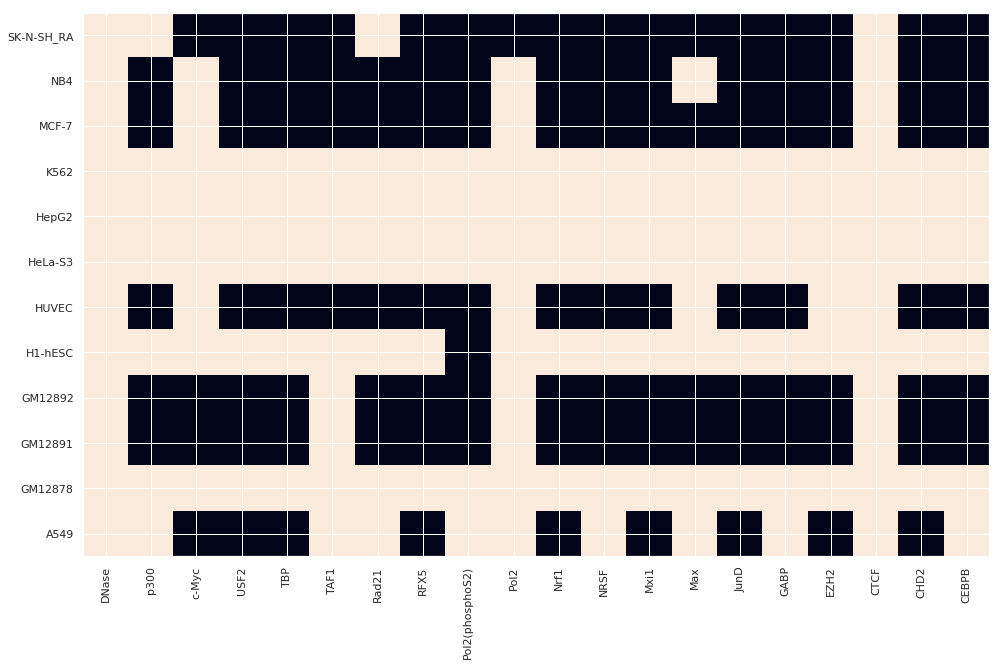

In [4]:
nv_assaymap = {v: k for k, v in assaymap.items()}

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.xticks(np.arange(len(assaymap)), rotation = 90)
ax.set_xticklabels(assaymap.keys())
plt.yticks(np.arange(len(cellmap)))
ax.set_yticklabels(cellmap.keys())

plt.imshow(matrix!=Label.UNK.value)

In [79]:
%%time
model_new = MLP(data,
            [],
            matrix,
            assaymap,
            cellmap,
            shuffle_size=2, 
            batch_size=64,
            train_indices = np.arange(0,10000))
model_new.train(5000)


I0717 11:40:08.235282 140234817853184 <ipython-input-78-f9d73242cfe7>:171] Starting Training


eval cell types ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549']
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.TRAIN
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.VALID
using [] as labels for mode Dataset.TEST
Error: no data, local variable 'x' referenced before assignment


I0717 11:40:10.594751 140234817853184 <ipython-input-78-f9d73242cfe7>:190] 0 tf.Tensor(0.020100897, shape=(), dtype=float32)
I0717 11:41:19.793307 140234817853184 <ipython-input-78-f9d73242cfe7>:190] 1000 tf.Tensor(0.00034677738, shape=(), dtype=float32)
I0717 11:42:30.890063 140234817853184 <ipython-input-78-f9d73242cfe7>:190] 2000 tf.Tensor(0.0009796696, shape=(), dtype=float32)
I0717 11:43:41.524928 140234817853184 <ipython-input-78-f9d73242cfe7>:190] 3000 tf.Tensor(0.00058731064, shape=(), dtype=float32)
I0717 11:44:51.917081 140234817853184 <ipython-input-78-f9d73242cfe7>:190] 4000 tf.Tensor(0.00057283154, shape=(), dtype=float32)


KeyboardInterrupt: 

In [15]:
validation_celltypes =  ['K562', 'HepG2', 'HeLa-S3', 'GM12878']
_, g = generator_to_tf_dataset(load_data(data[Dataset.VALID], 
                                               validation_celltypes, 
                                               model_new.eval_cell_types,
                                               model_new.matrix,
                                               model_new.assaymap,
                                               model_new.cellmap,
                                               radii = model_new.radii, mode = Dataset.VALID),
                                               model_new.batch_size, 1, model_new.prefetch_size)
results_original = model_new.test_from_generator(4000 * len(validation_celltypes), g)

using ['K562', 'HepG2', 'HeLa-S3', 'GM12878'] as labels for mode Dataset.VALID


I0716 15:15:26.498059 140321626511104 <ipython-input-13-c1e0c8d94740>:336] macro auROC:     0.9601205583645855
I0716 15:15:26.500786 140321626511104 <ipython-input-13-c1e0c8d94740>:337] auPRC:     0.35547266327858346
I0716 15:15:26.501853 140321626511104 <ipython-input-13-c1e0c8d94740>:338] GINI:     0.9202460297993713


In [16]:
def plot_ROC(results, TF, title=""):
    
    # plot ROC curve for RFX5
    fpr, tpr, _ = roc_curve(results[1][:,assaymap[TF]], results[0][:,assaymap[TF]])

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % results[3][TF]['AUC'])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s %s' % (TF, title))
    plt.legend(loc="lower right")
    plt.show()


# Curriculum learning

1. initialize missing labels for train (v)
2. train w (net) with partial labels
3. Repeat until no data is missing:
    - update v with easy labels. For now, easy labels are defined as getting close to 0 or 1 by distance theta
    - retrain w on new dataset


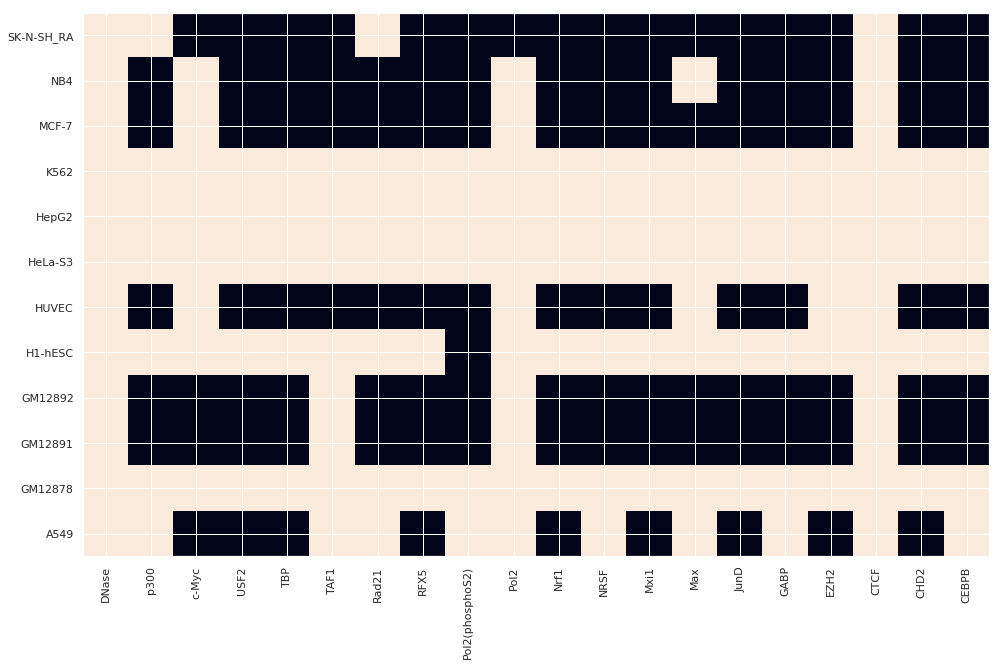

In [17]:

nv_assaymap = {v: k for k, v in assaymap.items()}

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.xticks(np.arange(len(assaymap)), rotation = 90)
ax.set_xticklabels(assaymap.keys())
plt.yticks(np.arange(len(cellmap)))
ax.set_yticklabels(cellmap.keys())

plt.imshow(matrix!=-1)


In [ ]:
# cifar ex https://github.com/tensorflow/probability/blob/80cc5cb33dfe04cb998bfe27ad3680a7a116d8b1/tensorflow_probability/examples/cifar10_bnn.py
# uses resnet https://github.com/tensorflow/probability/blob/80cc5cb33dfe04cb998bfe27ad3680a7a116d8b1/tensorflow_probability/examples/models/bayesian_resnet.py



In [75]:

def load_v_data(data, 
                 label_cell_types,  # used for labels. Should be all for train/eval and subset for test
                 eval_cell_types,   # used for rotating features. Should be all - test for train/eval
                 matrix,
                 assaymap,
                 cellmap,
                 radii,
                 **kwargs):
    
    # AM 5/20/2019. This is enforcing exclusive DNase bins and will make 
    # interpretation of DNase weights easier. It does not add performance benefit
    # over inclusive bins, which was used in the original model.
    exclusive = True

    """
    Takes Deepsea data and calculates distance metrics from cell types whose locations
    are specified by label_cell_indices, and the other cell types in the set. Label space is only one cell type.
     TODO AM 3/7/2019
    :param data: dictionary of matrices. Should have keys x and y. x contains n by 1000 rows. y contains n by 919 labels.
    :param label_cell_types: list of cell types to be rotated through and used as labels (subset of eval_cell_types)
    :param eval_cell_types: list of cell types to be used in evaluation (includes label_cell_types)
    :param matrix: matrix of celltype, assay positions
    :param assaymap: map of column assay positions in matrix
    :param cellmap: map of row cell type positions in matrix
    :param radii: radii to compute dnase distances from
    :param kwargs: kargs

    :returns: generator of data with three elements:
        1. record features
        2. record labels for a given cell type
        3. 0/1 mask of labels that have validation data. For example, if this record is for celltype A549,
        and A549 does not have data for ATF3, there will be a 0 in the position corresponding to the label space.
    """
    # set all UNKs features to TF mean
    def TF_mean(i, idx, cell_indices):
        """
        Gets the mean TF binding score for an element in this location
        """
        # compute means at row i in data for all assays
        indices = matrix[cell_indices,:].T.flatten()
        tmp1 = data[:,i][indices].astype(None)
        tmp1[tmp1 == Label.UNK.value] = np.nan
        tmp1[tmp1 == Label.IMPUTED_BOUND.value] = Label.BOUND.value
        tmp1[tmp1 == Label.IMPUTED_UNBOUND.value] = Label.UNBOUND.value
        means = np.nanmean(tmp1.reshape([len(cell_indices),  matrix.shape[1]]), axis=0) 
        
        TF_idx = idx % matrix.shape[1]
        return means[TF_idx]

    # Running in TRAIN, VALID, or TEST?    
    mode = kwargs.get("mode")
    # specifies the indices to generate records.
    # can be used for debug purposes, or to evaluate
    # only specific regions in a vector
    # TODO AM 4/17/2019: move this to an actual parameter
    indices = kwargs.get("indices")
    
    if (not isinstance(indices, np.ndarray) and not isinstance(indices, list)):
        indices = range(0, data.shape[-1]) # if not defined, set to all points
    
    if (not isinstance(mode, Dataset)):
        raise ValueError("mode is not a Dataset enum")
        
    if (mode == Dataset.RUNTIME):
        label_cell_types = ["PLACEHOLDER_CELL"]
        dnase_vector = kwargs.get("dnase_vector")
        random_cell = list(cellmap)[0] # placeholder to get label vector length
        
    print("using %s as labels for mode %s" % (label_cell_types, mode))
    
    # string of radii for meta data labeling
    radii_str = list(map(lambda x: "DNASE_RADII_%i" % x, radii))
        
    if (mode == Dataset.TEST or mode == Dataset.RUNTIME):
        # Drop cell types with the least information (TODO AM 4/1/2019 this could do something smarter)
        
        # make dictionary of eval_cell_type: assay count and sort in decreasing order
        tmp = matrix.copy()
        tmp[tmp >= Label.UNBOUND.value] = 1
        tmp[tmp == Label.UNK.value] = 0 
        sums = np.sum(tmp, axis = 1)
        cell_assay_counts = zip(list(cellmap), sums)
        cell_assay_counts = sorted(cell_assay_counts, key = lambda x: x[1])
        # filter by eval_cell_types
        cell_assay_counts = list(filter(lambda x: x[0] in eval_cell_types, cell_assay_counts))
        
        # remove cell types with smallest number of factors
        eval_cell_types = eval_cell_types.copy()
        [eval_cell_types.remove(i[0]) for i in cell_assay_counts[0:len(label_cell_types)]]
        del tmp
        del cell_assay_counts
        
        
    def g():
        for i in indices: # for all records specified
            for (cell) in label_cell_types: # for all cell types to be used in labels
                dnases = [] 
                dnases_double_positive = []
                dnases_agreement = []
                
                # cells to be featurized
                feature_cells = eval_cell_types.copy()
                
                # try to remove cell if it is in the possible list of feature cell types
                try:
                    feature_cells.remove(cell) 
                except ValueError:
                    pass  # do nothing!
                                
                # features from all remaining cells not in label set
                feature_cell_indices_list = list(map(lambda c: get_y_indices_for_cell(matrix, cellmap, c), 
                                                     feature_cells))
                feature_cell_indices = np.array(feature_cell_indices_list).flatten()
                
                                
                # labels for this cell
                if (mode != Dataset.RUNTIME):
                    label_cell_indices = get_y_indices_for_cell(matrix, cellmap, cell)
                    label_cell_indices_no_dnase = np.delete(label_cell_indices, [0])
                    labels = data[label_cell_indices_no_dnase,i]

                    # Copy assay_index_no_dnase and turn into mask of 0/1 for whether data for this cell type for
                    # a given label is available.
                    assay_mask = np.ones(labels.shape)
                    # set mask over missing AND imputed mask
                    assay_mask[labels < Label.UNBOUND.value] = 0
                else:
                    label_count = len(get_y_indices_for_cell(matrix, cellmap, random_cell))-1
                    
                    # Mask and labels are all 0's because labels are missing during runtime
                    garbage_labels = assay_mask = np.zeros(label_count)
                    # The features going into the example.
                    labels = garbage_labels # all 0's

                # get dnase indices for cell types that are going to be features
                dnase_indices = np.array([x[0] for x in feature_cell_indices_list])
                
                for r, radius in enumerate(radii):
                    
                    min_radius = max(0, i - radius + 1)
                    max_radius = min(i+radius, data.shape[1])
                    
                    # if exclusive == True, then do not featurize chromatin regions
                    # that were considered in smaller radii
                    if (exclusive and r != 0):
                        radius_range_1 = np.arange(min_radius, max(0, i - radii[r-1]+1))
                        radius_range_2 = np.arange(i+radii[r-1], max_radius)
                        
                        radius_range = np.concatenate([radius_range_1, radius_range_2])
                    else:
                        
                        radius_range = np.arange(min_radius, max_radius)
                        
                        
                    ####################################################################
                    
                    # use DNase vector, if it is provided
                    if (mode == Dataset.RUNTIME):

                        # within the radius, fraction of places where they are both 1
                        dnase_double_positive = np.average(data[dnase_indices[:,None],radius_range]*
                                                 dnase_vector[radius_range], axis=1)

                        # within the radius, fraction of places where they are both equal (0 or 1)
                        dnase_agreement = np.average(data[dnase_indices[:,None],radius_range]==
                                                 dnase_vector[radius_range], axis=1)

                    else:
                        # within the radius, fraction of places where they are both 1
                        # label_cell_index[0] == DNase location for specific cell type
                        dnase_double_positive = np.average(data[dnase_indices[:,None],radius_range]*
                                                 data[label_cell_indices[0],radius_range], axis=1)

                        # within the radius, fraction of places where they are both equal (0 or 1)
                        dnase_agreement = np.average(data[dnase_indices[:,None],radius_range]==
                                                 data[label_cell_indices[0],radius_range], axis=1)
                        
                    dnases_double_positive.extend(dnase_double_positive)
                    dnases_agreement.extend(dnase_agreement)
                        
                # rehape agreement DNase to Radii by feature_cells
                dnases_agreement_reshaped = np.array(dnases_agreement).reshape([len(radii), len(feature_cells)])
                dnases_double_positive_reshaped = np.array(dnases_double_positive).reshape([len(radii), len(feature_cells)])
                dnase_means = np.mean(dnases_agreement_reshaped, axis = 0)

                ######### reorder cells by similarity ################
                ## This was added 5/30/2019. It seems to *maybe help 
                ## a little bit on cell types not seen in the model.
                ## This makes sense because cell types are now ordered
                ## by similarity and keep some spacial positioning 
                ## based on the similarity to the new cell. 
                best_indices = (-dnase_means).argsort()

                dnases.extend(dnases_double_positive_reshaped[:,best_indices].flatten())
                dnases.extend(dnases_agreement_reshaped[:,best_indices].flatten())

                feature_cell_indices = feature_cell_indices.reshape([len(feature_cells), len(assaymap)])[best_indices,:].flatten()
                ######## End reorder #################################                                                   
                                                                        
                                                                        
                # Extract features
                features = data[feature_cell_indices,i]
                
                # concatenate features and DNases
                x_data = np.concatenate([features, dnases])
                
                # mask for x_data. 0 = do not mask, 1 = mask.
                x_mask = np.zeros(x_data.shape[0])
                # mask imputed (bound and unbound) and missing features
                x_mask[np.where(features == Label.UNK.value)[0]] = True # assign mask to missing features

                # There can be NaNs in the DNases for edge cases (when the radii extends past the end of the chr).
                # Mask these values in the first row of tmp
                x_mask[np.where(np.isnan(x_data))[0]] = True # assign mask to missing DNase values
                x_data[np.where(x_mask == True)[0]] = 0 # set all UNKs to 0
                
                # reset imputed values to normal known values in x_data
                x_data[np.where(x_data == Label.IMPUTED_BOUND.value)[0]] = Label.BOUND.value 
                x_data[np.where(x_data == Label.IMPUTED_UNBOUND.value)[0]] = Label.UNBOUND.value 
                
                # recalculate missing values as means
                masked_indices = np.where(x_mask == True)[0][:len(feature_cell_indices)]
                cellmap_idx = list(map(lambda x: cellmap[x], feature_cells))
                x_data[masked_indices] = TF_mean(i, masked_indices, cellmap_idx)
                
                # TODO 7.17.2019 this was modified to get train() to work 
                # because categorical does not accept negatives values. 
                labels[labels == -1] = 0
                
#                 x_data_masked = np.vstack([x_mask, x_data]) # top row 0 = mask, bottom row 1 = data
                yield (x_data, labels, assay_mask)

    return g

In [97]:
"""
Functions and classes for model specifications.
"""


################### Simple DNase peak based distance model ############

class CurriculumModel():
    def __init__(self,
                 data,
                 test_celltypes,
                 matrix,
                 assaymap,
                 cellmap,  
                 debug = False,
                 batch_size=64,
                 shuffle_size=10,
                 prefetch_size=10,
                 l1=0.,
                 l2=0.,
                 lr=1e-3,
                 radii=[1,3,10,30], 
                 train_indices = None):
        
        """
        Peak Model
        :param data: either a path to TF records OR a dictionary of TRAIN, VALID, and TEST data
        :param test_celltypes
        :param matrix
        :param assaymap
        :param cellmap
        :param debug: used to print out intermediate validation values
        :param batch_size
        :param shuffle_size
        :param prefetch_size
        :param l1
        :param l2
        :param lr
        :param radii
        :param train_indices: option numpy array of indices to train from data[Dataset.TRAIN]
        """
        
        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

        assert (set(test_celltypes) < set(list(cellmap))), \
                "test_celltypes %s must be subsets of available cell types %s" % (str(test_celltypes), str(list(cellmap)))

        # get evaluation cell types by removing any cell types that would be used in test
        self.eval_cell_types = list(cellmap).copy()
        self.test_celltypes = test_celltypes
        [self.eval_cell_types.remove(test_cell) for test_cell in self.test_celltypes]
        print("eval cell types", self.eval_cell_types)
        self.output_shape, self.train_iter = generator_to_tf_dataset(load_v_data(data[Dataset.TRAIN],  
                                                self.eval_cell_types,
                                                self.eval_cell_types,
                                                matrix,
                                                assaymap,
                                                cellmap,
                                                radii = radii, mode = Dataset.TRAIN),
                                                batch_size, shuffle_size, prefetch_size)

        _,            self.valid_iter = generator_to_tf_dataset(load_v_data(data[Dataset.VALID], 
                                                self.eval_cell_types,
                                                self.eval_cell_types,
                                                matrix,
                                                assaymap,
                                                cellmap,
                                                radii = radii, mode = Dataset.VALID), 
                                                batch_size, 1, prefetch_size)

        # can be empty if len(test_celltypes) == 0
        _,            self.test_iter = generator_to_tf_dataset(load_v_data(data[Dataset.TEST], 
                                               self.test_celltypes, 
                                               self.eval_cell_types,
                                               matrix,
                                               assaymap,
                                               cellmap,
                                               radii = radii, mode = Dataset.TEST),
                                               batch_size, 1, prefetch_size)

        self.num_outputs = self.output_shape[0]
        self.l1, self.l2 = l1, l2
        self.lr = lr
        self.batch_size = batch_size
        self.prefetch_size = prefetch_size
        self.shuffle_size = shuffle_size
        self.optimizer = tf.keras.optimizers.Adam(lr=self.lr)

        # set self
        self.model = self.create_model()
        self.radii = radii
        self.debug = debug
        self.assaymap = assaymap
        self.test_celltypes = test_celltypes
        self.matrix = matrix
        self.assaymap= assaymap 
        self.cellmap = cellmap
        self.data = data

            
    def save(self, checkpoint_path):
        """
        Saves model.
        
        :param checkpoint_path: string file path to save model to. 
        """
        # save keras model
        self.model.save(checkpoint_path)
        
        # save model params to pickle file
        dict_ = {'test_celltypes':self.test_celltypes,
                         'matrix':self.matrix,
                         'assaymap':self.assaymap,
                         'cellmap':self.cellmap,  
                         'debug': self.debug,
                         'batch_size':self.batch_size,
                         'shuffle_size':self.shuffle_size,
                         'prefetch_size':self.prefetch_size,
                         'radii':self.radii}
        
        fileObject = open(os.path.join(checkpoint_path, "model_params.pickle"),'wb')
        pickle.dump(dict_,fileObject)   
        fileObject.close()
        
        
    def gini(self, actual, pred, sample_weight):                                                 
        df = sorted(zip(actual, pred), key=lambda x : (x[1], x[0]),  reverse=True)
        random = [float(i+1)/float(len(df)) for i in range(len(df))]                
        totalPos = np.sum([x[0] for x in df])           
        cumPosFound = np.cumsum([x[0] for x in df])                                     
        Lorentz = [float(x)/totalPos for x in cumPosFound]                          
        Gini = np.array([l - r for l, r in zip(Lorentz, random)])
        # mask Gini with weights
        Gini[np.where(sample_weight == 0)[0]] = 0
        return np.sum(Gini)    

    def gini_normalized(self, actual, pred, sample_weight = None):              
        normalized_gini = self.gini(actual, pred, sample_weight)/self.gini(actual, actual, sample_weight)      
        return normalized_gini       

    def body_fn(self):
        raise NotImplementedError()
        
    def g(self, p, a=1, B=0, y=1):
        """ Normalization Function. Normalizes loss w.r.t. label proportion.

        Constraints: 
         1. g(p) = 1 when p = 1
         2. g(p) = a * p^y + B, where a, y and B are hyperparameters
        """
        return a * tf.math.pow(p, y) + B
    
    def loss_fn(self, y_true, y_pred, weights):
        # weighted sum of cross entropy for non 0 weights
        # Reduction method = Reduction.SUM_BY_NONZERO_WEIGHTS
        # TODO should be neg log likelihood + lk divergence ()
        loss = tf.compat.v1.losses.sigmoid_cross_entropy(y_true,  
                                                        y_pred, 
                                                        weights = weights,
                                                        reduction = tf.compat.v1.losses.Reduction.SUM_BY_NONZERO_WEIGHTS)

        assert(weights.shape)
        C = (len(self.assaymap)-1)
        p = tf.math.reduce_sum(weights, axis=1)/C # should be of dimension 1 by batch size
        normalized_loss = self.g(p)/C * loss
        kl = sum(self.model.losses) / weights.shape[-1]
        return normalized_loss + kl
        
    def train(self, num_steps, lr=None, checkpoint_path = None):
        if lr == None:
            lr = self.lr
            
        tf.compat.v1.logging.info("Starting Training")

#         @tf.function
        def train_step(inputs, labels, weights):
            logits = self.model(inputs, training=True)
            # separate distribution for each TF
            # TODO I don't think this distribution is right...
            print("logits", logits)
            # need to make different cat dist for each column
            labels_distribution = tfp.distributions.Categorical(logits=tf.reshape(logits, shape=[64,19,1]))
            # TODO
            print("lbl dist", labels_distribution)
            log_likelihood = labels_distribution.log_prob(labels)
            print("prob", log_likelihood)
            
            elbo_loss = self.loss_fn(log_likelihood, logits, weights)
            print(elbo_loss)
            
            train_op = self.optimizer.minimize(elbo_loss, self.model.weights)

            return elbo_loss
        
        for step, (inputs, labels, weights) in enumerate(self.train_iter.take(num_steps)): 

            loss = train_step(inputs, labels, weights)

            if step % 1000 == 0:
                tf.compat.v1.logging.info(str(step) + " " + str(tf.reduce_mean(loss)))
                
                if (self.debug):
                    tf.compat.v1.logging.info("On validation")
                    _, _, _, _, _ = self.test(40000, log=False)
                    tf.compat.v1.logging.info("")

    def test(self, num_samples, mode = Dataset.VALID, calculate_metrics=True):
        """
        Tests model on valid and test dataset handlers.
        """

        if (mode == Dataset.VALID):
            handle = self.valid_iter # for standard validation of validation cell types
            
        elif (mode == Dataset.TEST and len(self.test_celltypes) > 0):
            handle = self.test_iter # for standard validation of validation cell types        
        else:
            raise Exception("No data exists for %s. Use function test_from_generator() if you want to create a new iterator." % (mode))
            
        return self.run_predictions(num_samples, handle, calculate_metrics)      
        
    def test_from_generator(self, num_samples, ds, calculate_metrics=True):
        """
        Runs test given a specified data generator 
        :param num_samples: number of samples to test
        :param ds: tensorflow dataset, created by dataset_to_tf_dataset
        :param cell_type: cell type to test on. Used to generate holdout indices.
        
        :return predictions
        """
        return self.run_predictions(num_samples, ds, calculate_metrics)
    
    def eval_vector(self, data, vector, indices):
        """
        Evaluates a new cell type based on its chromatin (DNase or ATAC-seq) vector. len(vector) should equal
        the data.shape[1]
        :param data: data to build features from 
        :param vector: vector of 0s/1s of binding sites TODO AM 4/3/2019: try peak strength instead of 0s/1s
        :param indices: indices of vector to actually score. You need all of the locations for the generator.

        :return predictions for all factors
        """
        
        _,  ds = generator_to_tf_dataset(load_data(data, 
                 self.test_celltypes,   # used for labels. Should be all for train/eval and subset for test
                 self.eval_cell_types,   # used for rotating features. Should be all - test for train/eval
                 self.matrix,
                 self.assaymap,
                 self.cellmap,
                 radii = self.radii,
                 mode = Dataset.RUNTIME,
                 dnase_vector = vector, indices = indices), self.batch_size, 1, self.prefetch_size)

        num_samples = len(indices)
        
        preds, _, _, _, _ = self.run_predictions(num_samples, ds, calculate_metrics = False)    
        
        return preds

    def run_predictions(self, num_samples, iter_, calculate_metrics = True):
        """
        Runs predictions on num_samples records
        :param num_samples: number of samples to test
        :param iter_: output of self.sess.run(generator_to_one_shot_iterator()), handle to one shot iterator of records
        :param log: if true, logs individual factor accuracies
        
        :return preds, truth, assay_dict, auROC, auPRC, False
            preds = predictions, 
            truth = actual values, 
            sample_weight: 0/1 weights on predictions.  
            assay_dict = if log=True, holds predictions for individual factors
            auROC = average macro area under ROC for all factors with truth values
            auPRC = average area under PRC for all factors with truth values
        """
        
        inv_assaymap = {v: k for k, v in self.assaymap.items()}
                
        # batches of predictions
        vals = []

        for inputs, labels, weights in iter_.take(int(num_samples / self.batch_size)+1): 
            vals.append([tf.sigmoid(self.model(inputs, training=False)), inputs, labels, weights])

        preds = np.concatenate([v[0] for v in vals])
        preds = preds[:num_samples] # get feature row

        truth = np.concatenate([v[2] for v in vals])[:num_samples]
        sample_weight  = np.concatenate([v[3] for v in vals])[:num_samples]
        
        # reset truth back to 0 to compute metrics
        # sample weights will rule these out anyways when computing metrics
        truth_reset = np.copy(truth)
        truth_reset[truth_reset < Label.UNBOUND.value] = 0 
                                           
        # do not continue to calculate metrics. Just return predictions and true values
        if (not calculate_metrics):
            return preds, truth, sample_weight, None, None, None

        assert(preds.shape == sample_weight.shape)

        try:
            # Mean results because sample_weight mask can only work on 1 row at a time.
            # If a given assay is not available for evaluation, sample_weights will all be 0 
            # and the resulting roc_auc_score will be NaN.
            auROC_vec = []
            auPRC_vec = []
            GINI_vec =  []


            # try/accept for cases with only one class (throws ValueError)
            assay_dict = {}

            for j in range(preds.shape[1]): # for all assays
                assay = inv_assaymap[j+1] 

                roc_score = np.NAN

                try:
                    roc_score = sklearn.metrics.roc_auc_score(truth_reset[:,j], preds[:,j], 
                                                      average='macro', 
                                                      sample_weight = sample_weight[:,j])

                    auROC_vec.append(roc_score)

                except ValueError:
                    roc_score = np.NaN

                try:
                    pr_score = sklearn.metrics.average_precision_score(truth_reset[:,j], preds[:,j], 
                                                             sample_weight = sample_weight[:, j])

                    auPRC_vec.append(pr_score)

                except ValueError:
                    pr_score = np.NaN

                try:
                    gini_score = self.gini_normalized(truth_reset[:,j], preds[:,j], 
                                                      sample_weight = sample_weight[:, j])

                    GINI_vec.append(gini_score)

                except ValueError:
                    gini_score = np.NaN

                assay_dict[assay] = {"AUC": roc_score, "auPRC": pr_score, "GINI": gini_score }


            auROC = np.nanmean(auROC_vec)
            auPRC = np.nanmean(auPRC_vec)

            tf.compat.v1.logging.info("macro auROC:     " + str(auROC))
            tf.compat.v1.logging.info("auPRC:     " + str(auPRC))
            tf.compat.v1.logging.info("GINI:     " + str(np.nanmean(GINI_vec)))
        except ValueError as v:
            auROC = None
            auPRC = None
            tf.compat.v1.logging.info("Failed to calculate metrics")

        return preds, truth, sample_weight, assay_dict, auROC, auPRC
        
    def score_peak_file(self, peak_file):
    
        # get peak_vector, which is a vector matching train set. Some peaks will not overlap train set, 
        # and their indices are stored in missing_idx for future use
        peak_vector, all_peaks = bedFile2Vector(peak_file)
        print("finished loading peak file")

        # only select peaks to score
        idx = np.where(peak_vector == 1)[0]
        
        if len(idx) == 0:
            raise ValueError("No positive peaks found in %s" % peak_file)

        all_data = np.concatenate((self.data[Dataset.TRAIN], self.data[Dataset.VALID], self.data[Dataset.TEST]), axis=1)

        # takes about 1.5 minutes for 100,000 regions TODO AM 4/3/2019 speed up generator
        predictions = self.eval_vector(all_data, peak_vector, idx)
        print("finished predictions...", predictions.shape)


        # get number of factors to fill in if values are missing
        num_factors = predictions[0].shape[0]

        # map predictions with genomic position 
        liRegions = load_allpos_regions()
        prediction_positions = itemgetter(*idx)(liRegions)
        zipped = list(zip(prediction_positions, predictions))

        # for each all_peaks, if 1, reduce means for all overlapping peaks in positions
        # else, set to 0s

        def reduceMeans(peak):
            if (peak[1] == 1):
                # parse region

                # filter overlapping predictions for this peak and take mean      
                res = map(lambda k: k[1], filter(lambda x: peak[0].overlaps(x[0], 100), zipped))
                arr = np.concatenate(list(map(lambda x: np.matrix(x), res)), axis = 0)
                return(peak[0], np.mean(arr, axis = 0))
            else:
                return(peak[0], np.zeros(num_factors)) 

        grouped = list(map(lambda x: np.matrix(reduceMeans(x)[1]), all_peaks))

        final = np.concatenate(grouped, axis=0)

        df = pd.DataFrame(final, columns=list(self.assaymap)[1:])

        # load in peaks to get positions and could be called only once
        # TODO why are you reading this in twice?
        df_pos = pd.read_csv(peak_file, sep="\t", header = None)[[0,1,2]]
        final_df = pd.concat([df_pos, df], axis=1)

        return final_df
            

class CLP(CurriculumModel):
    def __init__(self,
             *args,
             **kwargs):

        """ To resume model training, call:
            model2 = MLP(data = data, checkpoint="/home/eecs/akmorrow/epitome/out/models/test_model")
        """
        self.layers = 4
        self.num_units = [100, 100, 100, 50]
        self.activation = tf.tanh
                          
        if "checkpoint" in kwargs.keys():
            fileObject = open(kwargs["checkpoint"] + "/model_params.pickle" ,'rb')
            metadata = pickle.load(fileObject)
            CurriculumModel.__init__(self, kwargs["data"], **metadata)
            self.model = tf.keras.models.load_model(kwargs["checkpoint"])
            
        elif "model" in kwargs.keys():
            # load in programmatic model with weights
            CurriculumModel.__init__(self, *args)
            self.model = kwargs["model"]
        else: 
            CurriculumModel.__init__(self, *args)
            
            
    def create_model(self):
        
        # this is called like model(data, training = True)
        model = tf.keras.Sequential()
        
        if not isinstance(self.num_units, collections.Iterable):
            self.num_units = [self.num_units] * self.layers
        for i in range(self.layers):
            model.add(tfp.layers.DenseFlipout(self.num_units[i], activation = self.activation))

        # output layer
        model.add(tfp.layers.DenseFlipout(self.num_outputs))
        model.build(input_shape = [64,308]) # TODO
        
        return model

clp_model = CLP(v,
        [],
        matrix_rebuilt,
        assaymap,
        cellmap,
        shuffle_size=2, 
        batch_size=64)

clp_model.train(10)



eval cell types ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549']
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.TRAIN
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.VALID
using [] as labels for mode Dataset.TEST
Error: no data, local variable 'x' referenced before assignment


I0717 17:06:39.774862 140223369754368 <ipython-input-97-8c5f0ebcbef0>:173] Starting Training


logits tf.Tensor(
[[-0.13787591  0.69442713  0.20938744 ...  0.24779242  0.5244956
  -0.31930494]
 [ 0.49288872  0.06897613 -0.43961257 ...  0.12452382  0.23271266
   0.0132787 ]
 [ 0.25712126  0.29009196 -0.2720549  ...  0.18904753  0.8907248
   0.11584166]
 ...
 [-0.0320205   0.44131702 -0.31095684 ...  0.09763657 -0.12923516
   0.23983294]
 [ 0.4162971   0.57037175 -0.151763   ...  0.441061   -0.31780687
   0.3029868 ]
 [-0.16463748  0.09464943 -0.3842644  ...  0.24359861  0.42356718
   0.35714614]], shape=(64, 19), dtype=float32)
lbl dist tfp.distributions.Categorical("Categorical/", batch_shape=[64, 19], event_shape=[], dtype=int32)


InvalidArgumentError: Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 [Op:SparseSoftmaxCrossEntropyWithLogits]

In [95]:

# Copyright 2018 The TensorFlow Probability Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================
"""Trains a Bayesian neural network to classify CIFAR-10 images.
The architecture can be either ResNet [1] or VGG [2].
To run with default arguments:
  ```
  bazel run tensorflow_probability/examples:cifar10_bnn
  ```
#### References
[1]: He, Kaiming, Xiangyu Zhang, Shaoqing Ren, and Jian Sun.
     "Deep residual learning for image recognition."
     _Proceedings of the IEEE_, 2016.
     https://arxiv.org/abs/1512.03385
[2]: Simonyan, Karen, and Andrew Zisserman.
     "Very deep convolutional networks for large-scale image recognition."
     arXiv preprint arXiv:1409.1556 (2014).
     https://arxiv.org/pdf/1409.1556.pdf
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import warnings

# Dependency imports
from absl import flags
import matplotlib
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

matplotlib.use("Agg")
warnings.simplefilter(action="ignore")
tfd = tfp.distributions

IMAGE_SHAPE = [32, 32, 3]

flags.DEFINE_float("learning_rate",
                   default=0.0001,
                   help="Initial learning rate.")
flags.DEFINE_integer("epochs",
                     default=700,
                     help="Number of epochs to train for.")
flags.DEFINE_integer("batch_size",
                     default=128,
                     help="Batch size.")
flags.DEFINE_string("data_dir",
                    default=os.path.join(os.getenv("TEST_TMPDIR", "/tmp"),
                                         "bayesian_neural_network/data"),
                    help="Directory where data is stored (if using real data).")
flags.DEFINE_string(
    "model_dir",
    default=os.path.join(os.getenv("TEST_TMPDIR", "/tmp"),
                         "bayesian_neural_network/"),
    help="Directory to put the model's fit.")
flags.DEFINE_integer("eval_freq",
                     default=400,
                     help="Frequency at which to validate the model.")
flags.DEFINE_integer("num_monte_carlo",
                     default=50,
                     help="Network draws to compute predictive probabilities.")
flags.DEFINE_string("architecture",
                    default="resnet",
                    help="Network architecture to use.")
flags.DEFINE_float(
    "kernel_posterior_scale_mean",
    default=-9.0,
    help="Initial kernel posterior mean of the scale (log var) for q(w)")
flags.DEFINE_float(
    "kernel_posterior_scale_constraint",
    default=0.2,
    help="Posterior kernel constraint for the scale (log var) of q(w).")
flags.DEFINE_integer("kl_annealing",
                     default=50,
                     help="Epochs to anneal the KL term (anneals from 0 to 1)")
flags.DEFINE_boolean("subtract_pixel_mean",
                     default=True,
                     help="Boolean for normalizing the images")
flags.DEFINE_bool("fake_data",
                  default=None,
                  help="If true, uses fake data. Defaults to real data.")


FLAGS = flags.FLAGS


def build_input_pipeline(x_train, x_test, y_train, y_test,
                         batch_size, valid_size):
  """Build an Iterator switching between train and heldout data."""

  x_train = x_train.astype("float32")
  x_test = x_test.astype("float32")

  x_train /= 255
  x_test /= 255

  y_train = y_train.flatten()
  y_test = y_test.flatten()

  if FLAGS.subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

  print("x_train shape:" + str(x_train.shape))
  print(str(x_train.shape[0]) + " train samples")
  print(str(x_test.shape[0]) + " test samples")

  # Build an iterator over training batches.
  training_dataset = tf.data.Dataset.from_tensor_slices(
      (x_train, np.int32(y_train)))
  training_batches = training_dataset.shuffle(
      50000, reshuffle_each_iteration=True).repeat().batch(batch_size)
  training_iterator = tf.compat.v1.data.make_one_shot_iterator(training_batches)

  # Build a iterator over the heldout set with batch_size=heldout_size,
  # i.e., return the entire heldout set as a constant.
  heldout_dataset = tf.data.Dataset.from_tensor_slices(
      (x_test, np.int32(y_test)))
  heldout_batches = heldout_dataset.repeat().batch(valid_size)
  heldout_iterator = tf.compat.v1.data.make_one_shot_iterator(heldout_batches)

  # Combine these into a feedable iterator that can switch between training
  # and validation inputs.
  handle = tf.compat.v1.placeholder(tf.string, shape=[])
  feedable_iterator = tf.compat.v1.data.Iterator.from_string_handle(
      handle, training_batches.output_types, training_batches.output_shapes)
  images, labels = feedable_iterator.get_next()

  return images, labels, handle, training_iterator, heldout_iterator


def build_fake_data():
  """Build fake CIFAR10-style data for unit testing."""
  num_examples = 10
  x_train = np.random.rand(num_examples, *IMAGE_SHAPE).astype(np.float32)
  y_train = np.random.permutation(np.arange(num_examples)).astype(np.int32)
  x_test = np.random.rand(num_examples, *IMAGE_SHAPE).astype(np.float32)
  y_test = np.random.permutation(np.arange(num_examples)).astype(np.int32)
  return (x_train, y_train), (x_test, y_test)


def main(argv):
  del argv  # unused
  if tf.io.gfile.exists(FLAGS.model_dir):
    tf.compat.v1.logging.warning(
        "Warning: deleting old log directory at {}".format(FLAGS.model_dir))
    tf.io.gfile.rmtree(FLAGS.model_dir)
  tf.io.gfile.makedirs(FLAGS.model_dir)

  if FLAGS.fake_data:
    (x_train, y_train), (x_test, y_test) = build_fake_data()
  else:
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

  (images, labels, handle,
   training_iterator,
   heldout_iterator) = build_input_pipeline(x_train, x_test, y_train, y_test,
                                            FLAGS.batch_size, 500)

  if FLAGS.architecture == "resnet":
    model_fn = bayesian_resnet
  else:
    model_fn = bayesian_vgg

  model = model_fn(
      IMAGE_SHAPE,
      num_classes=10,
      kernel_posterior_scale_mean=FLAGS.kernel_posterior_scale_mean,
      kernel_posterior_scale_constraint=FLAGS.kernel_posterior_scale_constraint)
  logits = model(images)
  labels_distribution = tfd.Categorical(logits=logits)

  # Perform KL annealing. The optimal number of annealing steps
  # depends on the dataset and architecture.
  t = tf.compat.v2.Variable(0.0)
  kl_regularizer = t / (FLAGS.kl_annealing * len(x_train) / FLAGS.batch_size)

  # Compute the -ELBO as the loss. The kl term is annealed from 0 to 1 over
  # the epochs specified by the kl_annealing flag.
  log_likelihood = labels_distribution.log_prob(labels)
  neg_log_likelihood = -tf.reduce_mean(input_tensor=log_likelihood)
  kl = sum(model.losses) / len(x_train) * tf.minimum(1.0, kl_regularizer)
  loss = neg_log_likelihood + kl

  # Build metrics for evaluation. Predictions are formed from a single forward
  # pass of the probabilistic layers. They are cheap but noisy
  # predictions.
  predictions = tf.argmax(input=logits, axis=1)
  with tf.compat.v1.name_scope("train"):
    train_accuracy, train_accuracy_update_op = tf.compat.v1.metrics.accuracy(
        labels=labels, predictions=predictions)
    opt = tf.compat.v1.train.AdamOptimizer(FLAGS.learning_rate)
    train_op = opt.minimize(loss)
    update_step_op = tf.compat.v1.assign(t, t + 1)

  with tf.compat.v1.name_scope("valid"):
    valid_accuracy, valid_accuracy_update_op = tf.compat.v1.metrics.accuracy(
        labels=labels, predictions=predictions)

  init_op = tf.group(tf.compat.v1.global_variables_initializer(),
                     tf.compat.v1.local_variables_initializer())

  stream_vars_valid = [
      v for v in tf.compat.v1.local_variables() if "valid/" in v.name
  ]
  reset_valid_op = tf.compat.v1.variables_initializer(stream_vars_valid)

  with tf.compat.v1.Session() as sess:
    sess.run(init_op)

    # Run the training loop
    train_handle = sess.run(training_iterator.string_handle())
    heldout_handle = sess.run(heldout_iterator.string_handle())
    training_steps = int(
        round(FLAGS.epochs * (len(x_train) / FLAGS.batch_size)))
    for step in range(training_steps):
      _ = sess.run([train_op,
                    train_accuracy_update_op,
                    update_step_op],
                   feed_dict={handle: train_handle})

      # Manually print the frequency
      if step % 100 == 0:
        loss_value, accuracy_value, kl_value = sess.run(
            [loss, train_accuracy, kl], feed_dict={handle: train_handle})
        print(
            "Step: {:>3d} Loss: {:.3f} Accuracy: {:.3f} KL: {:.3f}".format(
                step, loss_value, accuracy_value, kl_value))

      if (step + 1) % FLAGS.eval_freq == 0:
        # Compute log prob of heldout set by averaging draws from the model:
        # p(heldout | train) = int_model p(heldout|model) p(model|train)
        #                   ~= 1/n * sum_{i=1}^n p(heldout | model_i)
        # where model_i is a draw from the posterior
        # p(model|train).
        probs = np.asarray([sess.run((labels_distribution.probs),
                                     feed_dict={handle: heldout_handle})
                            for _ in range(FLAGS.num_monte_carlo)])
        mean_probs = np.mean(probs, axis=0)

        _, label_vals = sess.run(
            (images, labels), feed_dict={handle: heldout_handle})
        heldout_lp = np.mean(np.log(mean_probs[np.arange(mean_probs.shape[0]),
                                               label_vals.flatten()]))
        print(" ... Held-out nats: {:.3f}".format(heldout_lp))

        # Calculate validation accuracy
        for _ in range(20):
          sess.run(
              valid_accuracy_update_op, feed_dict={handle: heldout_handle})
        valid_value = sess.run(
            valid_accuracy, feed_dict={handle: heldout_handle})

        print(
            " ... Validation Accuracy: {:.3f}".format(valid_value))

        sess.run(reset_valid_op)


if __name__ == "__main__":
  tf.compat.v1.app.run()


/data/miniconda3/envs/EpitomeEnv_c76/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.


 12361728/170498071 [=>............................] - ETA: 1:05

KeyboardInterrupt: 

In [93]:
x[0][1]

array([0, 2, 8, 9, 3, 1, 4, 6, 5, 7], dtype=int32)

In [66]:
x = np.ones([64, 19])

tf.reshape(x, shape=[64,19,1])

<tf.Tensor: id=29502, shape=(64, 19, 1), dtype=float64, numpy=
array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]])>

In [ ]:
v = {}
v[Dataset.TRAIN] = init_v(cellmap, data[Dataset.TRAIN])
v[Dataset.TEST]  = init_v(cellmap, data[Dataset.TEST])
v[Dataset.VALID] = init_v(cellmap, data[Dataset.VALID])

In [8]:
def init_v(cellmap, data):
    """
    Initialize label space for cell types
    
    return: dict of cell types. each cell type as an np matrix 
    sized n points by # assays
    """
    n = data.shape[1]
    v = []
    for cell in cellmap:
        t = data[matrix[cellmap[cell],:],:].astype(int)
        # fill in unknowns
        t[np.where(matrix[cellmap[cell],:] == Label.UNK.value)[0],:]=-1
        if v == []:
            v = t
        else:
            v = np.vstack([v,t])
    # check that final result is the right size
    assert(v.shape[0] / len(assaymap) == len(cellmap))
    assert(v.shape[1] == n)
        
    return v



In [11]:

# build new matrix for new data structure. 
matrix_rebuilt = np.arange(0, len(assaymap) * len(cellmap)).reshape([len(cellmap), len(assaymap)])

In [11]:
#macro auROC:     0.909127812019869
# I0717 10:34:35.495405 140234817853184 models.py:793] auPRC:     0.4152977404988368
# I0717 10:34:35.496418 140234817853184 models.py:794] GINI:     0.8173336785347651



v = {}
v[Dataset.TRAIN] = init_v(cellmap, data[Dataset.TRAIN])
v[Dataset.TEST]  = init_v(cellmap, data[Dataset.TEST])
v[Dataset.VALID] = init_v(cellmap, data[Dataset.VALID])
print("v")
clp_model = CLP(v,
        [],
        matrix_rebuilt,
        assaymap,
        cellmap,
        shuffle_size=2, 
        batch_size=64)

clp_model.train(5000)
clp_model.test(4000)

/data/miniconda3/envs/EpitomeEnv_c76/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
I0717 10:27:34.922264 140234817853184 models.py:621] Starting Training


v
eval cell types ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549']
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.TRAIN
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.VALID
using [] as labels for mode Dataset.TEST
Error: no data, local variable 'x' referenced before assignment


I0717 10:27:37.881912 140234817853184 models.py:640] 0 tf.Tensor(0.018772308, shape=(), dtype=float32)
I0717 10:28:58.718099 140234817853184 models.py:640] 1000 tf.Tensor(0.0009159837, shape=(), dtype=float32)
I0717 10:30:20.947120 140234817853184 models.py:640] 2000 tf.Tensor(0.0016088438, shape=(), dtype=float32)
I0717 10:31:43.948346 140234817853184 models.py:640] 3000 tf.Tensor(0.000651206, shape=(), dtype=float32)
I0717 10:33:06.156315 140234817853184 models.py:640] 4000 tf.Tensor(4.1056963e-05, shape=(), dtype=float32)
I0717 10:34:35.493003 140234817853184 models.py:792] macro auROC:     0.909127812019869
I0717 10:34:35.495405 140234817853184 models.py:793] auPRC:     0.4152977404988368
I0717 10:34:35.496418 140234817853184 models.py:794] GINI:     0.8173336785347651


(array([[0.00511625, 0.00109109, 0.00097099, ..., 0.00098628, 0.00076634,
         0.00255802],
        [0.0071907 , 0.00132039, 0.00112757, ..., 0.00080287, 0.00101849,
         0.0028199 ],
        [0.05331868, 0.02062234, 0.01480144, ..., 0.00151876, 0.01877964,
         0.02166906],
        ...,
        [0.12720075, 0.02666298, 0.02659202, ..., 0.01026103, 0.01029524,
         0.13078669],
        [0.12949303, 0.02722302, 0.02743766, ..., 0.01056316, 0.01044273,
         0.13424605],
        [0.12492487, 0.02587533, 0.02562973, ..., 0.00976986, 0.01007146,
         0.12643313]], dtype=float32),
 array([[ 0., -1., -1., ...,  0., -1., -1.],
        [-1.,  0., -1., ...,  0., -1., -1.],
        [-1.,  0., -1., ...,  0., -1., -1.],
        ...,
        [-1.,  0., -1., ...,  0., -1., -1.],
        [-1.,  0., -1., ...,  0., -1., -1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.]], dtype=float32),
 array([[1., 0., 0., ..., 1., 0., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        [0., 1.,

In [41]:
%%time

v = {}
v[Dataset.TRAIN] = init_v(cellmap, data[Dataset.TRAIN][:,0:10000])
v[Dataset.TEST]  = init_v(cellmap, data[Dataset.TEST])
v[Dataset.VALID] = init_v(cellmap, data[Dataset.VALID])
    
def train(old_model, v):

    # reset training at a random location
    rand_n = np.random.randint(0, v[Dataset.TRAIN].shape[1])
                
    new_model = CLP(v,
        [],
        old_model.matrix,
        old_model.assaymap,
        old_model.cellmap,
        model = old_model.model,
        shuffle_size=old_model.shuffle_size, 
        train_indices = np.arange(rand_n, v[Dataset.TRAIN].shape[1]),
        batch_size=old_model.batch_size)

    new_model.train(500)
    return new_model

def indices_for_criteria(preds, truth, indices):
    
    m0 = 0.02 #np.mean(zeros)
    m1 =  0.3 # np.mean(ones)
    
    # select unknowns that are within 1 std of the means
    zeros_indices_filter = (preds < (m0))
    ones_indices_filter = (preds > (m1))

    one_indices = np.where((truth == Label.UNK.value) & (ones_indices_filter) & ~(zeros_indices_filter))
    zero_indices = np.where((truth == Label.UNK.value) & zeros_indices_filter & ~(ones_indices_filter))
    
    # reset column samples to original indices
    one_indices = [one_indices[0], indices[one_indices[1]]]
    zero_indices = [zero_indices[0], indices[zero_indices[1]]]
    
    return [zero_indices, one_indices]

def update_v_for_cell(v, preds, truth, cell, ind, in_place = True):
    """
    Updates matrix v with new preds based on selection criteria for whether example
    was 'easy' enough
    """
    # v is a (assay by celltype) by n matrix (n is number of training points)
    # rows are ordered by celltype 
    preds_T = preds.T
    # get indices of predictions that are 'easy' AND are unknown (truth == -1)
    indices = indices_for_criteria(preds_T, truth.T, ind)
    
    # get indices of v that start at the correct cell type
    # row number of first assay for cell in v
    cell_row_v = (len(assaymap) * cellmap[cell]) + 1 # + 1 to ignore DNase
    v_indices_0 = (indices[0][0] + cell_row_v, indices[0][1])
    v_indices_1 = (indices[1][0] + cell_row_v, indices[1][1])
    
    assert(np.all( v[v_indices_0[0], v_indices_0[1]] == Label.UNK.value))
    assert(np.all( v[v_indices_1[0], v_indices_1[1]] == Label.UNK.value))
    
    # set values
    v[v_indices_0[0], v_indices_0[1]] = Label.IMPUTED_UNBOUND.value
    v[v_indices_1[0], v_indices_1[1]] = Label.IMPUTED_BOUND.value
    
i = 0

total_iters = 5000/500 # normal model size / smaller model size

model = CLP(v,
        [],
        matrix_rebuilt,
        assaymap,
        cellmap,
        shuffle_size=2, 
        batch_size=64)

model.train(500)
    
while (i < total_iters ):
    
    print("iter %i" % i)
    
    if (i > 0):    
        # train v with labels
        model = train(model, v)
    
    # validate whole dataset and get new labels
    
    for cell in model.eval_cell_types:

        # get indices that have any -1s in them and run in generator for this cell
        cell_row_v = (len(assaymap) * cellmap[cell])
        t1 = v[Dataset.TRAIN][cell_row_v:cell_row_v+len(assaymap),:] == Label.UNK.value
        indices = np.where(t1.any(axis=0))[0]


        print("%s is missing data for %i samples" % (cell, len(indices)))
        if (len(indices) > 0):
                             
            _, ds = generator_to_tf_dataset(load_v_data(v[Dataset.TRAIN], [cell], model.eval_cell_types,
                                                   model.matrix, model.assaymap, model.cellmap, radii = model.radii,
                                                   mode = Dataset.TRAIN, indices = indices), model.batch_size, 1, model.prefetch_size)

            preds, truth, weights, _, _, _ = model.test_from_generator(len(indices), ds, False)
            print(preds.shape)

            # update v with easy labels
            update_v_for_cell(v[Dataset.TRAIN], preds, truth, cell, indices)
            print("updated %s, %i remaining..." % (cell, (v[Dataset.TRAIN][v[Dataset.TRAIN] == Label.UNK.value].shape[0])))
        
        
    i = i + 1
    
print("done")
        

/data/miniconda3/envs/EpitomeEnv_c76/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
I0716 16:43:01.227626 140321626511104 <ipython-input-38-b50cb40dd6a7>:169] Starting Training


eval cell types ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549']
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.TRAIN
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.VALID
using [] as labels for mode Dataset.TEST
Error: no data, local variable 'x' referenced before assignment


I0716 16:43:03.878045 140321626511104 <ipython-input-38-b50cb40dd6a7>:188] 0 tf.Tensor(0.023579327, shape=(), dtype=float32)


iter 0
SK-N-SH_RA is missing data for 10000 samples
using ['SK-N-SH_RA'] as labels for mode Dataset.TRAIN
(10000, 19)
updated SK-N-SH_RA, 880122 remaining...
NB4 is missing data for 10000 samples
using ['NB4'] as labels for mode Dataset.TRAIN
(10000, 19)
updated NB4, 738263 remaining...
MCF-7 is missing data for 10000 samples
using ['MCF-7'] as labels for mode Dataset.TRAIN
(10000, 19)
updated MCF-7, 587189 remaining...
K562 is missing data for 0 samples
HepG2 is missing data for 0 samples
HeLa-S3 is missing data for 0 samples
HUVEC is missing data for 10000 samples
using ['HUVEC'] as labels for mode Dataset.TRAIN
(10000, 19)
updated HUVEC, 455210 remaining...
H1-hESC is missing data for 10000 samples
using ['H1-hESC'] as labels for mode Dataset.TRAIN
(10000, 19)
updated H1-hESC, 445561 remaining...
GM12892 is missing data for 10000 samples
using ['GM12892'] as labels for mode Dataset.TRAIN
(10000, 19)
updated GM12892, 294637 remaining...
GM12891 is missing data for 10000 samples
using

I0716 16:45:30.350737 140321626511104 <ipython-input-38-b50cb40dd6a7>:169] Starting Training


(10000, 19)
updated A549, 58338 remaining...
iter 1
eval cell types ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549']
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.TRAIN
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.VALID
using [] as labels for mode Dataset.TEST
Error: no data, local variable 'x' referenced before assignment


I0716 16:45:33.231537 140321626511104 <ipython-input-38-b50cb40dd6a7>:188] 0 tf.Tensor(0.0014970214, shape=(), dtype=float32)


SK-N-SH_RA is missing data for 1237 samples
using ['SK-N-SH_RA'] as labels for mode Dataset.TRAIN
(1237, 19)
updated SK-N-SH_RA, 56770 remaining...
NB4 is missing data for 974 samples
using ['NB4'] as labels for mode Dataset.TRAIN
(974, 19)
updated NB4, 55495 remaining...
MCF-7 is missing data for 1137 samples
using ['MCF-7'] as labels for mode Dataset.TRAIN
(1137, 19)
updated MCF-7, 54285 remaining...
K562 is missing data for 0 samples
HepG2 is missing data for 0 samples
HeLa-S3 is missing data for 0 samples
HUVEC is missing data for 1056 samples
using ['HUVEC'] as labels for mode Dataset.TRAIN
(1056, 19)
updated HUVEC, 53207 remaining...
H1-hESC is missing data for 351 samples
using ['H1-hESC'] as labels for mode Dataset.TRAIN
(351, 19)
updated H1-hESC, 53200 remaining...
GM12892 is missing data for 1239 samples
using ['GM12892'] as labels for mode Dataset.TRAIN
(1239, 19)
updated GM12892, 52158 remaining...
GM12891 is missing data for 1140 samples
using ['GM12891'] as labels for mod

I0716 16:46:24.795698 140321626511104 <ipython-input-38-b50cb40dd6a7>:169] Starting Training


(868, 19)
updated A549, 50496 remaining...
iter 2
eval cell types ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549']
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.TRAIN
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.VALID
using [] as labels for mode Dataset.TEST
Error: no data, local variable 'x' referenced before assignment


I0716 16:46:27.456321 140321626511104 <ipython-input-38-b50cb40dd6a7>:188] 0 tf.Tensor(0.0005901767, shape=(), dtype=float32)


SK-N-SH_RA is missing data for 1053 samples
using ['SK-N-SH_RA'] as labels for mode Dataset.TRAIN
(1053, 19)
updated SK-N-SH_RA, 48924 remaining...
NB4 is missing data for 892 samples
using ['NB4'] as labels for mode Dataset.TRAIN
(892, 19)
updated NB4, 47531 remaining...
MCF-7 is missing data for 1055 samples
using ['MCF-7'] as labels for mode Dataset.TRAIN
(1055, 19)
updated MCF-7, 45993 remaining...
K562 is missing data for 0 samples
HepG2 is missing data for 0 samples
HeLa-S3 is missing data for 0 samples
HUVEC is missing data for 1022 samples
using ['HUVEC'] as labels for mode Dataset.TRAIN
(1022, 19)
updated HUVEC, 44738 remaining...
H1-hESC is missing data for 344 samples
using ['H1-hESC'] as labels for mode Dataset.TRAIN
(344, 19)
updated H1-hESC, 44668 remaining...
GM12892 is missing data for 1198 samples
using ['GM12892'] as labels for mode Dataset.TRAIN
(1198, 19)
updated GM12892, 43221 remaining...
GM12891 is missing data for 1113 samples
using ['GM12891'] as labels for mod

I0716 16:47:19.575977 140321626511104 <ipython-input-38-b50cb40dd6a7>:169] Starting Training


(836, 19)
updated A549, 40918 remaining...
iter 3
eval cell types ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549']
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.TRAIN
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.VALID
using [] as labels for mode Dataset.TEST
Error: no data, local variable 'x' referenced before assignment


I0716 16:47:22.387395 140321626511104 <ipython-input-38-b50cb40dd6a7>:188] 0 tf.Tensor(6.52919e-05, shape=(), dtype=float32)


SK-N-SH_RA is missing data for 935 samples
using ['SK-N-SH_RA'] as labels for mode Dataset.TRAIN
(935, 19)
updated SK-N-SH_RA, 40455 remaining...
NB4 is missing data for 824 samples
using ['NB4'] as labels for mode Dataset.TRAIN
(824, 19)
updated NB4, 40035 remaining...
MCF-7 is missing data for 956 samples
using ['MCF-7'] as labels for mode Dataset.TRAIN
(956, 19)
updated MCF-7, 39626 remaining...
K562 is missing data for 0 samples
HepG2 is missing data for 0 samples
HeLa-S3 is missing data for 0 samples
HUVEC is missing data for 959 samples
using ['HUVEC'] as labels for mode Dataset.TRAIN
(959, 19)
updated HUVEC, 39364 remaining...
H1-hESC is missing data for 274 samples
using ['H1-hESC'] as labels for mode Dataset.TRAIN
(274, 19)
updated H1-hESC, 39284 remaining...
GM12892 is missing data for 1115 samples
using ['GM12892'] as labels for mode Dataset.TRAIN
(1115, 19)
updated GM12892, 38853 remaining...
GM12891 is missing data for 1028 samples
using ['GM12891'] as labels for mode Data

I0716 16:48:12.943579 140321626511104 <ipython-input-38-b50cb40dd6a7>:169] Starting Training


(759, 19)
updated A549, 38144 remaining...
iter 4
eval cell types ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549']
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.TRAIN
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.VALID
using [] as labels for mode Dataset.TEST
Error: no data, local variable 'x' referenced before assignment


I0716 16:48:15.612344 140321626511104 <ipython-input-38-b50cb40dd6a7>:188] 0 tf.Tensor(0.00055005914, shape=(), dtype=float32)


SK-N-SH_RA is missing data for 934 samples
using ['SK-N-SH_RA'] as labels for mode Dataset.TRAIN
(934, 19)
updated SK-N-SH_RA, 37949 remaining...
NB4 is missing data for 821 samples
using ['NB4'] as labels for mode Dataset.TRAIN
(821, 19)
updated NB4, 37802 remaining...
MCF-7 is missing data for 955 samples
using ['MCF-7'] as labels for mode Dataset.TRAIN
(955, 19)
updated MCF-7, 37641 remaining...
K562 is missing data for 0 samples
HepG2 is missing data for 0 samples
HeLa-S3 is missing data for 0 samples
HUVEC is missing data for 959 samples
using ['HUVEC'] as labels for mode Dataset.TRAIN
(959, 19)
updated HUVEC, 37525 remaining...
H1-hESC is missing data for 194 samples
using ['H1-hESC'] as labels for mode Dataset.TRAIN
(194, 19)
updated H1-hESC, 37523 remaining...
GM12892 is missing data for 1115 samples
using ['GM12892'] as labels for mode Dataset.TRAIN
(1115, 19)
updated GM12892, 37359 remaining...
GM12891 is missing data for 1027 samples
using ['GM12891'] as labels for mode Data

I0716 16:49:06.240923 140321626511104 <ipython-input-38-b50cb40dd6a7>:169] Starting Training


(733, 19)
updated A549, 37117 remaining...
iter 5
eval cell types ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549']
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.TRAIN
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.VALID
using [] as labels for mode Dataset.TEST
Error: no data, local variable 'x' referenced before assignment


I0716 16:49:09.011913 140321626511104 <ipython-input-38-b50cb40dd6a7>:188] 0 tf.Tensor(5.287087e-05, shape=(), dtype=float32)


SK-N-SH_RA is missing data for 929 samples
using ['SK-N-SH_RA'] as labels for mode Dataset.TRAIN
(929, 19)
updated SK-N-SH_RA, 36633 remaining...
NB4 is missing data for 821 samples
using ['NB4'] as labels for mode Dataset.TRAIN
(821, 19)
updated NB4, 36282 remaining...
MCF-7 is missing data for 955 samples
using ['MCF-7'] as labels for mode Dataset.TRAIN
(955, 19)
updated MCF-7, 35906 remaining...
K562 is missing data for 0 samples
HepG2 is missing data for 0 samples
HeLa-S3 is missing data for 0 samples
HUVEC is missing data for 959 samples
using ['HUVEC'] as labels for mode Dataset.TRAIN
(959, 19)
updated HUVEC, 35494 remaining...
H1-hESC is missing data for 192 samples
using ['H1-hESC'] as labels for mode Dataset.TRAIN
(192, 19)
updated H1-hESC, 35488 remaining...
GM12892 is missing data for 1114 samples
using ['GM12892'] as labels for mode Dataset.TRAIN
(1114, 19)
updated GM12892, 35205 remaining...
GM12891 is missing data for 1027 samples
using ['GM12891'] as labels for mode Data

I0716 16:49:59.145826 140321626511104 <ipython-input-38-b50cb40dd6a7>:169] Starting Training


(700, 19)
updated A549, 34759 remaining...
iter 6
eval cell types ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549']
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.TRAIN
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.VALID
using [] as labels for mode Dataset.TEST
Error: no data, local variable 'x' referenced before assignment


I0716 16:50:01.631097 140321626511104 <ipython-input-38-b50cb40dd6a7>:188] 0 tf.Tensor(0.00060113886, shape=(), dtype=float32)


SK-N-SH_RA is missing data for 898 samples
using ['SK-N-SH_RA'] as labels for mode Dataset.TRAIN
(898, 19)
updated SK-N-SH_RA, 34395 remaining...
NB4 is missing data for 819 samples
using ['NB4'] as labels for mode Dataset.TRAIN
(819, 19)
updated NB4, 34119 remaining...
MCF-7 is missing data for 952 samples
using ['MCF-7'] as labels for mode Dataset.TRAIN
(952, 19)
updated MCF-7, 33843 remaining...
K562 is missing data for 0 samples
HepG2 is missing data for 0 samples
HeLa-S3 is missing data for 0 samples
HUVEC is missing data for 956 samples
using ['HUVEC'] as labels for mode Dataset.TRAIN
(956, 19)
updated HUVEC, 33551 remaining...
H1-hESC is missing data for 186 samples
using ['H1-hESC'] as labels for mode Dataset.TRAIN
(186, 19)
updated H1-hESC, 33537 remaining...
GM12892 is missing data for 1112 samples
using ['GM12892'] as labels for mode Dataset.TRAIN
(1112, 19)
updated GM12892, 33254 remaining...
GM12891 is missing data for 1026 samples
using ['GM12891'] as labels for mode Data

I0716 16:50:51.830036 140321626511104 <ipython-input-38-b50cb40dd6a7>:169] Starting Training


(697, 19)
updated A549, 32769 remaining...
iter 7
eval cell types ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549']
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.TRAIN
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.VALID
using [] as labels for mode Dataset.TEST
Error: no data, local variable 'x' referenced before assignment


I0716 16:50:54.373154 140321626511104 <ipython-input-38-b50cb40dd6a7>:188] 0 tf.Tensor(5.5328863e-05, shape=(), dtype=float32)


SK-N-SH_RA is missing data for 888 samples
using ['SK-N-SH_RA'] as labels for mode Dataset.TRAIN
(888, 19)
updated SK-N-SH_RA, 32520 remaining...
NB4 is missing data for 819 samples
using ['NB4'] as labels for mode Dataset.TRAIN
(819, 19)
updated NB4, 32314 remaining...
MCF-7 is missing data for 941 samples
using ['MCF-7'] as labels for mode Dataset.TRAIN
(941, 19)
updated MCF-7, 32060 remaining...
K562 is missing data for 0 samples
HepG2 is missing data for 0 samples
HeLa-S3 is missing data for 0 samples
HUVEC is missing data for 952 samples
using ['HUVEC'] as labels for mode Dataset.TRAIN
(952, 19)
updated HUVEC, 31814 remaining...
H1-hESC is missing data for 172 samples
using ['H1-hESC'] as labels for mode Dataset.TRAIN
(172, 19)
updated H1-hESC, 31807 remaining...
GM12892 is missing data for 1104 samples
using ['GM12892'] as labels for mode Dataset.TRAIN
(1104, 19)
updated GM12892, 31566 remaining...
GM12891 is missing data for 1017 samples
using ['GM12891'] as labels for mode Data

I0716 16:51:44.495695 140321626511104 <ipython-input-38-b50cb40dd6a7>:169] Starting Training


(691, 19)
updated A549, 31237 remaining...
iter 8
eval cell types ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549']
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.TRAIN
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.VALID
using [] as labels for mode Dataset.TEST
Error: no data, local variable 'x' referenced before assignment


I0716 16:51:47.237716 140321626511104 <ipython-input-38-b50cb40dd6a7>:188] 0 tf.Tensor(0.00041239354, shape=(), dtype=float32)


SK-N-SH_RA is missing data for 858 samples
using ['SK-N-SH_RA'] as labels for mode Dataset.TRAIN
(858, 19)
updated SK-N-SH_RA, 30895 remaining...
NB4 is missing data for 819 samples
using ['NB4'] as labels for mode Dataset.TRAIN
(819, 19)
updated NB4, 30674 remaining...
MCF-7 is missing data for 938 samples
using ['MCF-7'] as labels for mode Dataset.TRAIN
(938, 19)
updated MCF-7, 30411 remaining...
K562 is missing data for 0 samples
HepG2 is missing data for 0 samples
HeLa-S3 is missing data for 0 samples
HUVEC is missing data for 952 samples
using ['HUVEC'] as labels for mode Dataset.TRAIN
(952, 19)
updated HUVEC, 30161 remaining...
H1-hESC is missing data for 165 samples
using ['H1-hESC'] as labels for mode Dataset.TRAIN
(165, 19)
updated H1-hESC, 30145 remaining...
GM12892 is missing data for 1099 samples
using ['GM12892'] as labels for mode Dataset.TRAIN
(1099, 19)
updated GM12892, 29768 remaining...
GM12891 is missing data for 1010 samples
using ['GM12891'] as labels for mode Data

I0716 16:52:37.355173 140321626511104 <ipython-input-38-b50cb40dd6a7>:169] Starting Training


(685, 19)
updated A549, 29299 remaining...
iter 9
eval cell types ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549']
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.TRAIN
using ['SK-N-SH_RA', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.VALID
using [] as labels for mode Dataset.TEST
Error: no data, local variable 'x' referenced before assignment


I0716 16:52:39.911777 140321626511104 <ipython-input-38-b50cb40dd6a7>:188] 0 tf.Tensor(3.876345e-05, shape=(), dtype=float32)


SK-N-SH_RA is missing data for 835 samples
using ['SK-N-SH_RA'] as labels for mode Dataset.TRAIN
(835, 19)
updated SK-N-SH_RA, 28986 remaining...
NB4 is missing data for 810 samples
using ['NB4'] as labels for mode Dataset.TRAIN
(810, 19)
updated NB4, 28753 remaining...
MCF-7 is missing data for 927 samples
using ['MCF-7'] as labels for mode Dataset.TRAIN
(927, 19)
updated MCF-7, 28491 remaining...
K562 is missing data for 0 samples
HepG2 is missing data for 0 samples
HeLa-S3 is missing data for 0 samples
HUVEC is missing data for 945 samples
using ['HUVEC'] as labels for mode Dataset.TRAIN
(945, 19)
updated HUVEC, 28263 remaining...
H1-hESC is missing data for 149 samples
using ['H1-hESC'] as labels for mode Dataset.TRAIN
(149, 19)
updated H1-hESC, 28263 remaining...
GM12892 is missing data for 1068 samples
using ['GM12892'] as labels for mode Dataset.TRAIN
(1068, 19)
updated GM12892, 27918 remaining...
GM12891 is missing data for 990 samples
using ['GM12891'] as labels for mode Datas

In [42]:
# 2. test validation set without filling in missing values
# finally, test validation set
validation_celltypes = ['K562', 'HepG2', 'HeLa-S3', 'GM12878']
_, ds = generator_to_tf_dataset(load_v_data(v[Dataset.VALID], validation_celltypes, model.eval_cell_types,
                                                   model.matrix, model.assaymap, model.cellmap, radii = model.radii,
                                                   mode = Dataset.VALID), model.batch_size, 1, model.prefetch_size)
results2 = model.test_from_generator(v[Dataset.VALID].shape[1] * len(validation_celltypes), ds)


using ['K562', 'HepG2', 'HeLa-S3', 'GM12878'] as labels for mode Dataset.VALID


I0716 16:53:53.097610 140321626511104 <ipython-input-38-b50cb40dd6a7>:340] macro auROC:     0.920883702763667
I0716 16:53:53.100080 140321626511104 <ipython-input-38-b50cb40dd6a7>:341] auPRC:     0.2731459554264439
I0716 16:53:53.101133 140321626511104 <ipython-input-38-b50cb40dd6a7>:342] GINI:     0.8417816274298604


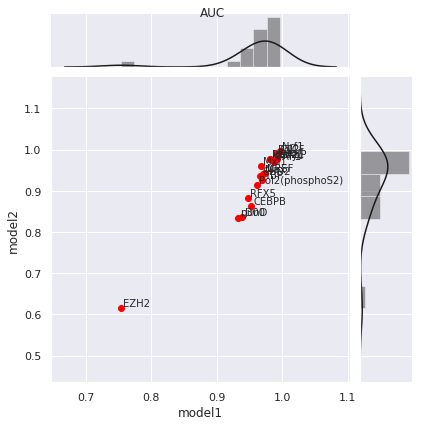

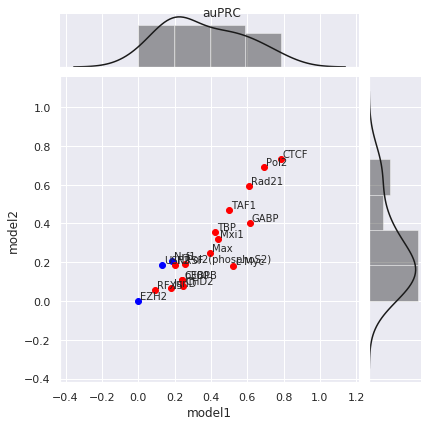

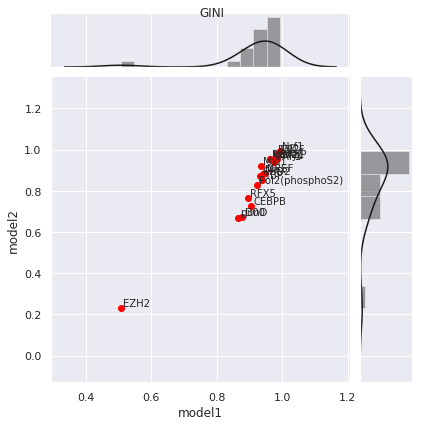

In [43]:
for i in results2[3]['CEBPB'].keys():
    joint_plot(results_original[3], 
                   results2[3], 
                   metric = i, 
                   model1_name = "model1", 
                   model2_name = "model2",
                   outlier_filter = "model2 > 0")

In [44]:
# 3. compute validation set but first fill in missing values
new_validation_set = np.copy(v[Dataset.VALID])
print("no of UNKS: ", new_validation_set[new_validation_set == Label.UNK.value].shape)

i = 0
updating = True
last_update_n = new_validation_set[new_validation_set == Label.UNK.value].shape[0]

while (updating):
    print("iter %i" % i)
    
    
    for cell in model.eval_cell_types:
        
        # get indices that have any -1s in them and run in generator for this cell
        cell_row_v = (len(assaymap) * cellmap[cell])
        t1 = v[Dataset.VALID][cell_row_v:cell_row_v+len(assaymap),:] == Label.UNK.value
        indices = np.where(t1.any(axis=0))[0]
        
        print("%s is missing data for %i samples" % (cell, len(indices)))
        if (len(indices) > 0):

            _, ds = generator_to_tf_dataset(load_v_data(new_validation_set, [cell], model.eval_cell_types,
                                                               model.matrix, model.assaymap, model.cellmap, radii = model.radii,
                                                               mode = Dataset.VALID, indices = indices), model.batch_size, 1, model.prefetch_size)

            preds, truth, weights, _, _, _ = model.test_from_generator(len(indices), ds, False)

            # update v with easy labels
            update_v_for_cell(new_validation_set, preds, truth, cell, indices)
            print("updated %s, %i remaining..." % (cell, (new_validation_set[new_validation_set == Label.UNK.value].shape[0])))
        
    new_update_n = new_validation_set[new_validation_set == Label.UNK.value].shape[0]
    
    if (new_update_n == last_update_n):
        updating = False # no new updates
    else:
        last_update_n = new_update_n
    i = i + 1
    
    
# finally, run evaluation

_, ds = generator_to_tf_dataset(load_v_data(new_validation_set, validation_celltypes, model.eval_cell_types,
                                                   model.matrix, model.assaymap, model.cellmap, radii = model.radii,
                                                   mode = Dataset.VALID), model.batch_size, 1, model.prefetch_size)

results3 = model.test_from_generator(new_validation_set.shape[1] * len(validation_celltypes), ds)


no of UNKS:  (412000,)
iter 0
SK-N-SH_RA is missing data for 4000 samples
using ['SK-N-SH_RA'] as labels for mode Dataset.VALID
updated SK-N-SH_RA, 350619 remaining...
NB4 is missing data for 4000 samples
using ['NB4'] as labels for mode Dataset.VALID
updated NB4, 292994 remaining...
MCF-7 is missing data for 4000 samples
using ['MCF-7'] as labels for mode Dataset.VALID
updated MCF-7, 231745 remaining...
K562 is missing data for 0 samples
HepG2 is missing data for 0 samples
HeLa-S3 is missing data for 0 samples
HUVEC is missing data for 4000 samples
using ['HUVEC'] as labels for mode Dataset.VALID
updated HUVEC, 177926 remaining...
H1-hESC is missing data for 4000 samples
using ['H1-hESC'] as labels for mode Dataset.VALID
updated H1-hESC, 173989 remaining...
GM12892 is missing data for 4000 samples
using ['GM12892'] as labels for mode Dataset.VALID
updated GM12892, 112228 remaining...
GM12891 is missing data for 4000 samples
using ['GM12891'] as labels for mode Dataset.VALID
updated GM

I0716 16:59:21.013330 140321626511104 <ipython-input-38-b50cb40dd6a7>:340] macro auROC:     0.9232312749636167
I0716 16:59:21.014461 140321626511104 <ipython-input-38-b50cb40dd6a7>:341] auPRC:     0.312094663562985
I0716 16:59:21.015434 140321626511104 <ipython-input-38-b50cb40dd6a7>:342] GINI:     0.8464780620826944


In [69]:
def plot_binding_distributions(results):
    # look at the distributions for binding, non-binding, missing, and imputed values
    preds = results[0]
    truth = results[1]
    zeros = preds[np.where((truth ==0))]
    ones = preds[np.where(truth == 1)]
    unks = preds[np.where(truth == Label.UNK.value)]
#     imp_zeros = ...
#     imp_ones = ...

    plt.hist(zeros, bins=50, alpha = 0.3, label="non-binding")
    plt.hist(ones, bins=50, alpha = 0.3, label="binding")
    plt.hist(unks, bins=50, alpha = 0.3, label="missing")

    plt.hist(imp_zeros, bins=50, alpha = 0.3, label="imputed non-binding")
    plt.hist(imp_ones, bins=50, alpha = 0.3, label="imputed binding")

    plt.gca().set_yscale("log")
    plt.legend()
    plt.show()

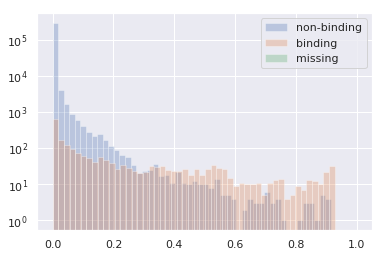

In [67]:
# look at the distributions for binding, non-binding, missing, and imputed values


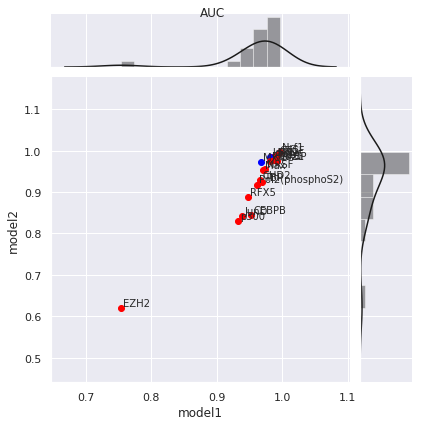

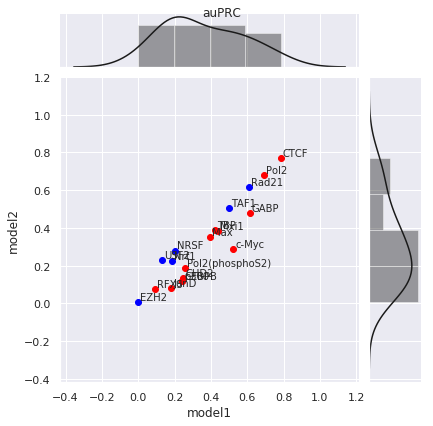

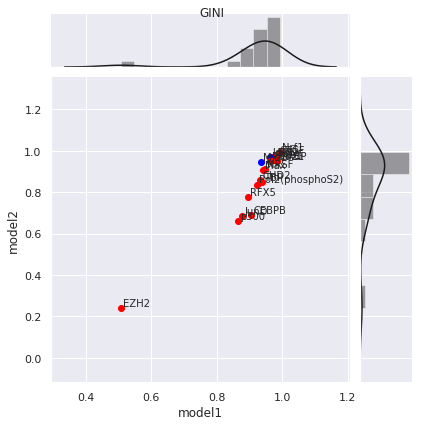

In [48]:
for i in results2[3]['CEBPB'].keys():
    joint_plot(results_original[3], 
                   results3[3], 
                   metric = i, 
                   model1_name = "model1", 
                   model2_name = "model2",
                   outlier_filter = "model2 > 0")

In [ ]:
for TF in results_original[3].keys():
    plot_ROC(results_original, TF, title="original")
    plot_ROC(results2, TF, title="no imputation")
    plot_ROC(results3, TF, title="imputation")